# Titanic: Machine Learning from Disaster

This notebook summarizes my efforts for working on the [Kaggle Titanic challenge](https://www.kaggle.com/c/titanic). The final ensemble method achieved a prediction accuracy of 0.78468 for the test set.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier

import warnings
warnings.filterwarnings('ignore')

## 1. Data import and wrangling

First, I will import training and test data and have a first look.

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
test_ids = test['PassengerId']

## Join train and test datasets in order to obtain the same number of features during data transformation
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
dataset = dataset.fillna(np.nan)

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


### Imputing missing values

In [7]:
dataset.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

While the missing values for the *Survived* attribute stems from the test data set, there are other missing values that have to be dealt with. I decided to fill the missing values as follows:

* *Age:* median within similar rows regarding the most correlated features with Age (Sex, Parch , Pclass and SibSp). If such a row does not exist, I will take the median from the corresponding passenger class.
* *Fare:* median within the corresponding passenger class
* *Embarked:* the only missing value will be replaced by the most frequent value
* *Cabin:* I will replace missing values by 'X'

In [8]:
dataset.Age = dataset.groupby(['Sex','Pclass','Parch','SibSp']).Age.transform(lambda x: x.fillna(x.median()))
dataset.Age = dataset.groupby('Pclass').Age.transform(lambda x: x.fillna(x.median()))
dataset.Fare = dataset.groupby('Pclass').Fare.transform(lambda x: x.fillna(x.median()))
dataset.Embarked = dataset.Embarked.fillna(dataset.Embarked.value_counts().idxmax())
dataset.Cabin = dataset.Cabin.fillna('X')

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


## 2. Feature selection / engineering

Now, I will look at the available data in more detail to identify significant features and decide to create new ones.

### Age

Let's look at the age of survivors versus the age of non-survivors.

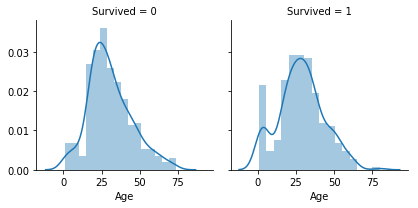

In [10]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

Clearly, the distributions are different. In particular, it appears that young children and especially babies were more likely to survive. I therefore decided to create additional features from the age column.

In [11]:
dataset['baby'] = (dataset.Age <= 1).astype(int)
dataset['toddler'] = ((dataset.Age > 1) & (dataset.Age <= 3)).astype(int)
dataset['minor'] = ((dataset.Age > 3) & (dataset.Age <= 18)).astype(int)
dataset['adult'] = (dataset.Age > 18).astype(int)

### Sex

In [12]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


Clearly, women were more likely to survive. But to use this feature efficiently, the data has to be transformed.

In [13]:
dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female':1})

### Passenger class

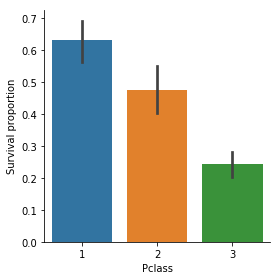

In [14]:
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar')
g = g.set_ylabels('Survival proportion')

Just like sex, the passenger class apears to have a significant influence on survival. To use the feature efficiently, I will convert the column to cummy variables.

In [15]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix='PC')

### Family size

The dataset contains the two columns *SibSp* (# of siblings / spouses aboard the Titanic) and *Parch* (# of parents / children aboard the Titanic).

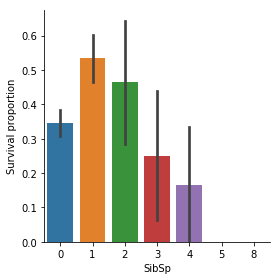

In [16]:
g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar')
g = g.set_ylabels('Survival proportion')

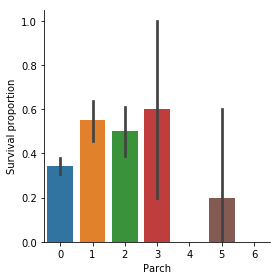

In [17]:
g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar')
g = g.set_ylabels('Survival proportion')

I decided to combine these two into a new feature *fam_size*:

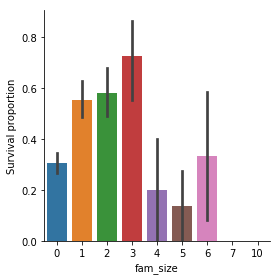

In [18]:
dataset['fam_size'] = dataset['Parch'] + dataset['SibSp']

g = sns.factorplot(x='fam_size', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival proportion')

Now, there appears to be a clear trend that medium size families (2-4 members) have a higher probability to survive compared to singles and large families (> 4 members). Therefore, I decided to create additional features for these:

In [19]:
dataset['single'] = (dataset['fam_size'] == 0).astype(int)
dataset['med_fam_size'] = ((dataset['fam_size'] > 0) & (dataset['fam_size'] <= 3)).astype(int)
dataset['large_fam_size'] = (dataset['fam_size'] > 3).astype(int)

### Fare

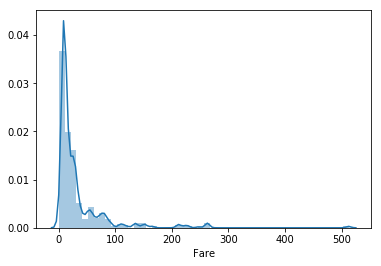

In [20]:
g = sns.distplot(dataset['Fare'])

In part 1, it could already be seen that Fare is correlated with survival. However, using Fare as a feature as is poses a problem due to its skewed distribution, which can lead to overweigth when fitting a model. Therefore I decided to transform Fare with a logarithmic transformation:

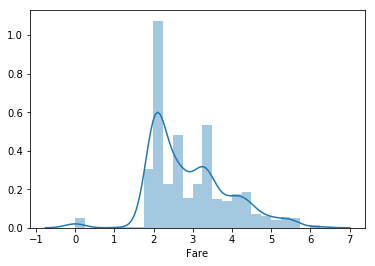

In [21]:
dataset['Fare'] = dataset['Fare'].apply(lambda x: np.log(x) if x > 0 else 0)
g = sns.distplot(dataset['Fare'])

### Embarked

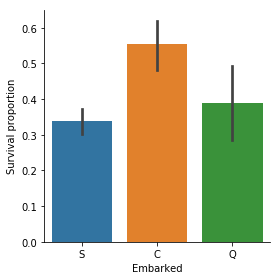

In [22]:
g = sns.factorplot(x='Embarked', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival proportion')

It appears that the port where passengers embarked is correlated with their survival. I Therefore, I am also adding dummy variables to use this information for predictions.

In [23]:
dataset['Embarked'] = dataset['Embarked'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix='Emb')

### Cabin

I decided to retain only the deck information, where *X* indicates missing cabin information.

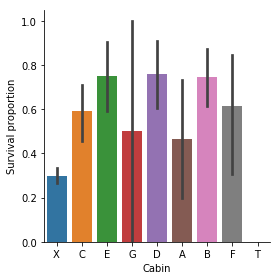

In [24]:
dataset['Cabin'] = dataset.Cabin.str[0]
g = sns.factorplot(x='Cabin', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival proportion')

The deck also seems to be somehow linked to survival, so I will add dummy variables.

In [25]:
dataset['Cabin'] = dataset['Cabin'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix='Cab')

### Final cleaning and preparing

At last, I will remove all non-needed columns: 

In [26]:
dataset.drop(labels = ['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)

In [27]:
dataset.columns

Index(['Age', 'Fare', 'Parch', 'Sex', 'SibSp', 'Survived', 'baby', 'toddler',
       'minor', 'adult', 'PC_1', 'PC_2', 'PC_3', 'fam_size', 'single',
       'med_fam_size', 'large_fam_size', 'Emb_C', 'Emb_Q', 'Emb_S', 'Cab_A',
       'Cab_B', 'Cab_C', 'Cab_D', 'Cab_E', 'Cab_F', 'Cab_G', 'Cab_T', 'Cab_X'],
      dtype='object')

## 3. Modelling

I decided to try the following popular classifiers and evaluate the mean accuracy of each of them using a stratified kfold cross validation procedure.

* Logistic regression
* Naive Bayes
* k-Nearest Neighbors
* Decision Tree
* Support Vector Machine
* Random Forest
* Extra Trees
* AdaBoost 
* Gradient Boosting

In [28]:
## Separate train dataset (features and labels) and test dataset
all_features = ['Age', 'Fare', 'Parch', 'Sex', 'SibSp', 'baby', 'toddler',
       'minor', 'adult', 'PC_1', 'PC_2', 'PC_3', 'fam_size', 'single',
       'med_fam_size', 'large_fam_size', 'Emb_C', 'Emb_Q', 'Emb_S', 'Cab_A',
       'Cab_B', 'Cab_C', 'Cab_D', 'Cab_E', 'Cab_F', 'Cab_G', 'Cab_T', 'Cab_X']
selected_features = ['Sex', 'PC_1', 'PC_2', 'PC_3', 'single', 'med_fam_size', 
                     'large_fam_size', 'Emb_C', 'Emb_Q', 'Emb_S']

X_train = dataset[:train_len].drop(labels = ["Survived"],axis=1)[selected_features]
Y_train = dataset[:train_len].Survived
X_test = dataset[train_len:].drop(labels=["Survived"], axis=1)[selected_features]

In [29]:
kfold = StratifiedKFold(n_splits=10)
random_state = 42

classifiers = []
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(GaussianNB())
classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state, learning_rate=0.1))
classifiers.append(GradientBoostingClassifier(random_state=random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring="accuracy", cv = kfold, n_jobs=2))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

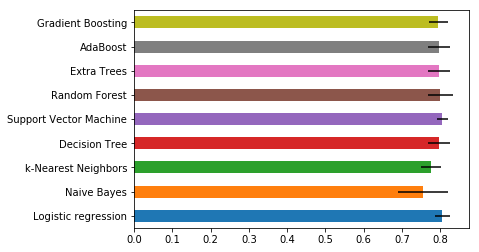

In [30]:
names = ['Logistic regression', 'Naive Bayes', 'k-Nearest Neighbors', 'Decision Tree', 'Support Vector Machine', 
         'Random Forest', 'Extra Trees', 'AdaBoost', 'Gradient Boosting']
    
cv_res = pd.DataFrame({'name': names, 'mean': cv_means, 'std': cv_std})
cv_res.plot(kind='barh', x='name', y='mean', xerr='std', legend=False)
plt.ylabel('')
plt.show()

Not too bad! I decided to further assess Support Vector Machine, Random Forest, ExtraTrees, AdaBoost and Gradient Boosting via grid search to optimize their parameters. Eventually, I will also use all of them for an ensemble classifier. 

In [31]:
def save_prediction(model, prefix):
    pred = pd.Series(model.predict(X_test), name="Survived").astype(int)
    results = pd.concat([test_ids, pred],axis=1)
    results.to_csv(prefix + '_submission.csv', index=False)
    
def myGridSearch(model, params):
    gs = GridSearchCV(model, param_grid=params, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)
    gs.fit(X_train, Y_train)
    best_model = gs.best_estimator_
    score = gs.best_score_
    print('Best accuracy score:', score)
    
    return (best_model, score)

### Support Vector Machine

In [32]:
svc_param_grid = {'kernel': ['rbf'], 'gamma': [ 0.001, 0.01, 0.1, 1], 'C': [1, 10, 50, 100,200,300, 1000]}

svc = SVC(probability=True)
svc_best, svc_score = myGridSearch(svc, svc_param_grid)
save_prediction(svc_best, 'svc')

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=2)]: Done  55 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done 277 out of 280 | elapsed:   22.1s remaining:    0.1s
[Parallel(n_jobs=2)]: Done 280 out of 280 | elapsed:   22.2s finished


Best accuracy score: 0.8103254769921436


### Random Forest

In [33]:
rf_param_grid = {"max_depth": [None], "max_features": [3, 5], "min_samples_split": [3, 5], 
                 "min_samples_leaf": [3, 5], "bootstrap": [False], "n_estimators" :[100], "criterion": ["gini"]}

rf = RandomForestClassifier()
rf_best, rf_score = myGridSearch(rf, rf_param_grid)
save_prediction(rf_best, 'rf')

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.9s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:    9.2s finished


Best accuracy score: 0.7968574635241302


### Extra Trees Classifier

In [34]:
et_param_grid = {"max_depth": [None], "max_features": [3, 5], "min_samples_split": [3, 5], 
                 "min_samples_leaf": [3, 5], "bootstrap": [False], "n_estimators" :[100], "criterion": ["gini"]}

et = ExtraTreesClassifier()
et_best, et_score = myGridSearch(et, et_param_grid)
save_prediction(et_best, 'et')

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:    8.1s finished


Best accuracy score: 0.7968574635241302


### AdaBoost

In [35]:
ab_param_grid = {"base_estimator__criterion": ["gini", "entropy"], "base_estimator__splitter": ["best", "random"],
                 "algorithm": ["SAMME","SAMME.R"], "n_estimators": [10, 20, 50], 
                 "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

dtc = DecisionTreeClassifier()
ab = AdaBoostClassifier(dtc)
ab_best, ab_score = myGridSearch(ab, ab_param_grid)
save_prediction(ab_best, 'ab')

Fitting 10 folds for each of 168 candidates, totalling 1680 fits


[Parallel(n_jobs=2)]: Done 170 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done 1070 tasks      | elapsed:   34.6s


Best accuracy score: 0.7968574635241302


[Parallel(n_jobs=2)]: Done 1680 out of 1680 | elapsed:  1.0min finished


### Gradient Boosting

In [36]:
gb_param_grid = {'loss' : ["deviance"], 'n_estimators' : [100,200,300], 'learning_rate': [0.1, 0.05, 0.01], 
                 'max_depth': [4, 8], 'min_samples_leaf': [100,150], 'max_features': [0.3, 0.1]}

gb = GradientBoostingClassifier(random_state = random_state)
gb_best, gb_score = myGridSearch(gb, gb_param_grid)
save_prediction(gb_best, 'gb')

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done  51 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done 351 tasks      | elapsed:   21.1s
[Parallel(n_jobs=2)]: Done 717 out of 720 | elapsed:   41.9s remaining:    0.1s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   42.1s finished


Best accuracy score: 0.8069584736251403


### Combining all classifiers as ensemble

In [37]:
from sklearn.ensemble import VotingClassifier

models = [('svc', svc_best), ('rfc', rf_best), ('etc', et_best), ('abc', ab_best), ('gbc', gb_best)]
voting_model = VotingClassifier(estimators=models, voting='soft')
voting_model.fit(X_train, Y_train)
voting_predictions = voting_model.predict(X_train)
accuracy_score(voting_predictions, Y_train)

0.8103254769921436

In [38]:
save_prediction(voting_model, 'ensemble')